In [1]:
from glob import glob
import os
import re
import sys
import random
import itertools
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

In [2]:
TABLEU_COLOURS = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                  (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                  (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                  (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                  (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]) / 255

In [3]:
from meta_loader import get_meta, emotions

In [4]:
class EmotionCounter(Counter, OrderedDict):
    
    def __init__(self, *args):
        for e in emotions:
            self[e] = 0
        super(EmotionCounter, self).__init__(*args)

In [5]:
# e_counter = EmotionCounter([e for f_name, s, e in meta_flat])
# print(e_counter)

# for m in filtered_meta:
#     e_counter = EmotionCounter([e for f_name, s, e in m])
#     print(e_counter.keys())
#     print(e_counter.values())


In [6]:
def draw_polar_plot(counter, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(9, 9), subplot_kw=dict(polar=True))
    plt.title(title, fontsize=24)
    ticks = list(np.arange(0, 2 * np.pi, 2 * np.pi / len(counter))) + [0]
    counts = list(counter.values())
    ax.plot(ticks, counts + [counts[0]])
    ax.fill(ticks, counts + [counts[0]], alpha=0.2)
    # ax.set_xticklabels(e_counter.keys(), fontsize=18)
    ax.set_xticklabels(counter.keys(), fontsize=18)
    # plt.tight_layout()
    ax.set_rlabel_position(90)
    label = ax.get_xticklabels()
    for l in label:
        l.set_bbox(dict(facecolor='white', edgecolor='black')) 
    plt.show()
    
def draw_histogram_plot(counter, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(7, 8))
    plt.title(title, fontsize=18)
    plt.bar(counter.keys(), counter.values(), width=0.6)
    plt.show()

def draw_multi_histogram_plot(counters_and_labels, title='', sharey=False):
#     fig, axes = plt.subplots(len(counters_and_labels), 1,
#                              figsize=(8, 3 * len(counters_and_labels)),
#                              sharey=sharey)
    plt.subplots(1, 1, figsize=(6, 8))
    plt.title(title, fontsize=18)
    last_peaks = np.zeros_like(list(counters_and_labels[0][0].values()))
    for i, (counter, label) in enumerate(counters_and_labels):
#         x = np.arange(len(counter.keys()))
        plt.bar(counter.keys(), counter.values(), 
               alpha=0.8, width=0.6, label=label,
               bottom=last_peaks,
               color=TABLEU_COLOURS[i % len(TABLEU_COLOURS)])
        last_peaks += np.array(list(counter.values()))
#     ax.set_xticks(x)
#     ax.set_xticklabels(counter.keys())
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(reversed(handles), reversed(labels), loc='upper right')
    plt.tight_layout()
    plt.show() 
    

In [7]:
dataset_keywords = ['ACRYL', 'CREMA-D', 'EMOV', 'ShEMO', 
                    'BAVED', 'ANAD', 'TESS', 'EEKK',
                    'JL-corpus', 'RAVDESS', 'VIVAE', 'URDU',   
                    'CaFE', 'AESDD', 'SAVEE']

In [8]:
meta = list(map(get_meta, dataset_keywords))

In [9]:
print('# Emtions')
print(emotions)
print()

filtered_meta = [list(filter(lambda x: x[2] in emotions, m)) for m in meta]

print('# Meta data size')
for name, m, f_m in zip(dataset_keywords, meta, filtered_meta):
    print(f'{name:10}: {len(m):>5} > {len(f_m):>5}')
print(f'{"SUM":10}: {sum(map(len, meta)):>5} > {sum(map(len, filtered_meta)):>5}')    
      
# for m in meta:
#     print(random.choice(m))   

# meta_flat = list(itertools.chain.from_iterable(meta))
meta_flat = list(itertools.chain.from_iterable(filtered_meta))

# Emtions
['happiness', 'anger', 'neutral', 'sadness', 'disgust', 'fear', 'surprise', 'sleepy']

# Meta data size
ACRYL     : 22087 > 22087
CREMA-D   :  7442 >  7442
EMOV      :  6893 >  6893
ShEMO     :  3000 >  3000
BAVED     :  1935 >  1257
ANAD      :  1334 >  1334
TESS      :  2800 >  2800
EEKK      :  1164 >  1164
JL-corpus :  2400 >   960
RAVDESS   :  1440 >  1248
VIVAE     :  1085 >   900
URDU      :   400 >   400
CaFE      :   936 >   936
AESDD     :   605 >   605
SAVEE     :   480 >   480
SUM       : 54001 > 51506


EmotionCounter({'happiness': 9078, 'anger': 9058, 'neutral': 8721, 'sadness': 6974, 'disgust': 6208, 'fear': 5401, 'surprise': 4345, 'sleepy': 1721})


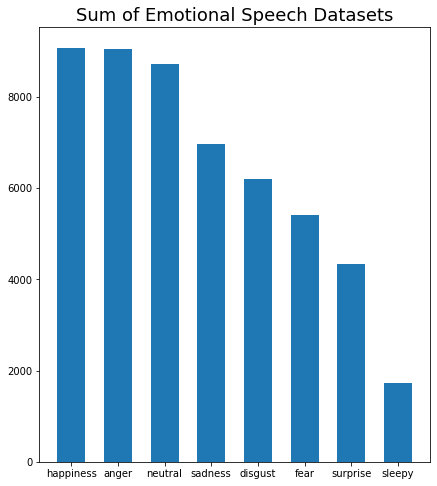

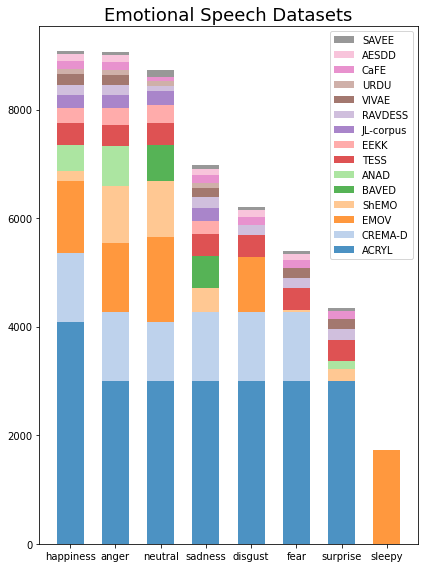

In [10]:
e_counter = EmotionCounter([e for f_name, s, e in meta_flat])

print(e_counter)

# draw_polar_plot(e_counter, 'Total')
draw_histogram_plot(e_counter, 'Sum of Emotional Speech Datasets')

counters = list()
for name, m in zip(dataset_keywords, filtered_meta):
    e_counter = EmotionCounter([e for f_name, s, e in m])
    counters.append((e_counter, name))
    
draw_multi_histogram_plot(counters, 'Emotional Speech Datasets')
#     draw_histogram_plot(e_counter, name)